In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.model_selection import train_test_split




# Dataset

In [2]:
def generate_halfmoon(n1, n2, max_angle=3.14):
    alpha = np.linspace(0, max_angle, n1)
    beta = np.linspace(0, max_angle, n2)
    x1 = np.vstack([np.cos(alpha), np.sin(alpha)]) + 0.1 * np.random.randn(2,n1)
    x2 = np.vstack([1 - np.cos(beta), 1 - np.sin(beta) - 0.5]) + 0.1 * np.random.randn(2,n2)
    y1, y2 = np.zeros(n1), np.ones(n2)
    X = np.hstack([x1, x2]).T
    y = np.hstack([y1, y2]).T
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0, shuffle = True, stratify = y)
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    return X_train, X_test, y_train, y_test


$$

z = x * w + b \\
\sigma = \frac{1}{1 + e ^ -z} \\
C(\sigma, y) = \frac{1}{n} \sum_1^n-y * log(\sigma) - (1-y) * log(1-\sigma) \\
\nabla C = \frac{1}{n} \sum_1^n (\sigma(x_i) - y_i)(x_j)
$$

In [3]:
from sympy.stats import Logistic, density, cdf
from sympy import Symbol, diff, Function, E, simplify, log
from sympy import E

w = Symbol('w')
b = Symbol('b')
x = Symbol('x')
n = Symbol('n')
y = Function('y')(w*x + b)
i = Symbol('i')
# y = Symbol('y')
p = 1/(1+E**(-y))
cost = -y * log(p) - (1-y) * log(1-p)
dw = diff(cost, w)
db = diff(cost, b)
simplify(dw)

x*(-(y(b + w*x) - 1)*exp(y(b + w*x)) + (exp(y(b + w*x)) + 1)*(-log(exp(y(b + w*x))/(exp(y(b + w*x)) + 1)) + log(1/(exp(y(b + w*x)) + 1))) - y(b + w*x))*Subs(Derivative(y(_xi_1), _xi_1), _xi_1, b + w*x)/(exp(y(b + w*x)) + 1)

# Problem 1

In [16]:
def sigmoid(z):
    return 1.0/(1 + np.exp(-z))

def loss(y:np.ndarray, y_hat:np.ndarray) -> float:
    """
    Calculate the loss.
    :param y: true/target value.
    :param y_hat: hypothesis/predictions.
    :return: loss.
    """
    loss = np.mean(y*(np.log(y_hat)) - (1-y)*np.log(1-y_hat))
    return loss

def gradients(x:np.ndarray, y:np.ndarray, y_hat:np.ndarray) -> tuple:
    """
    Calculate the gradients.
    :param x: input data.
    :param y: true/target value.
    :param y_hat: hypothesis/predictions.
    :return: weight gradient, bias gradient.
    """
    n = x.shape[0]
    # Gradient of loss w.r.t weights.
    dw = (1/n)*np.dot(x.T, (y_hat - y))
    # Gradient of loss w.r.t bias.
    db = (1/n)*np.sum((y_hat - y)) 
    return dw, db

def fit(x:np.ndarray, y:np.ndarray, bs:np.ndarray, epochs:int, lr:float, method:str = 'sgd') -> tuple:
    """
    Train the model.
    :param x: input data.
    :param y: true/target value.
    :param bs: batch size.
    :param epochs: number of epochs.
    :param lr: learning rate.
    :return: weights, bias.
    """
    m, n = x.shape
    # Setting initial weights and bias to 0.
    w = np.zeros((n,1))
    b = 0
    # Ensuring y is in the right shape.
    y = y.reshape(m,1)
    # Training the model.
    losses = []
    grads = []
    for epoch in range(epochs):
        for i in range((m-1)//bs + 1):
            # Finding the batches.
            start_i = i*bs
            end_i = start_i + bs
            xb = x[start_i:end_i]
            yb = y[start_i:end_i]
            # Predictions
            y_hat = sigmoid(np.dot(xb, w) + b)
            # Calculating the gradients.
            dw, db = gradients(xb, yb, y_hat)
            # Adjust the gradients
            if method == 'sgd':
                w -= lr*dw
                b -= lr*db
            elif method == 'accelerated':
                if not 'w_old' in locals():
                    w_old = w
                    b_old = b
                    k = 1
                else:
                    w_old = w
                    b_old = b
                    k = k + 1
                p_w = w_old + (k -1)/(k + 2) * (w - w_old)
                p_b = b_old + (k -1)/(k + 2) * (b - b_old)
                y_new = sigmoid(np.dot(xb, p_w) + p_b)
                dw, db = gradients(xb, yb, y_new)
                w = p_w - lr*dw
                b = p_b - lr*db
            elif method == 'adaptive':
                if not 'w_old' in locals():
                    w_old = 1
                    b_old = 1
                    a_1 = 1
                    a_2 = 1
                    eps = 1e-5
                    dw_old = 1
                    db_old = 1 + eps
                tmp1 = np.sqrt(1 + a_1/a_2) * a_1
                tmp2_W = np.linalg.norm(w - w_old)/(2 * np.linalg.norm(dw - dw_old))
                tmp2_B = np.linalg.norm(b - b_old)/(2 * np.linalg.norm(db - db_old))
                a_w = min(tmp1, tmp2_W)
                a_b = min(tmp1, tmp2_B)
                w = w - a_w * dw
                b = b - a_b * db
        # Finding the loss.
        l = loss(y, sigmoid(np.dot(x, w) + b))
        grad = np.linalg.norm(dw)
        losses.append(l)
        grads.append(grad)
    return w, b, losses, grads

def predict(x:np.ndarray, w:np.ndarray, b:np.ndarray, proba:bool = False) -> np.ndarray:
    """
    Predict the class of the input data.
    :param x: input data.
    :param w: weights.
    :param b: biases.
    :return: predictions.
    """
    preds = sigmoid(np.dot(x, w) + b)
    if not proba:
        pred_classes = []
        pred_classes = [1 if i > 0.5 else 0 for i in preds]
        preds = np.array(pred_classes)
    else:
        print("Returning probabilities.")
    return preds

def plot_decision_boundary(X:np.ndarray, y:np.ndarray, w:np.ndarray, b:np.ndarray, features:list = [0, 1]):
    if isinstance(X, np.ndarray):
        x1 = [min(X[:,features[0]]), max(X[:,features[0]])]
        feat1 = X[:,features[0]]
        feat2 = X[:,features[1]]
    elif isinstance(X, pd.DataFrame):
        x1 = [min(X[features[0]]), max(X[features[0]])]
        feat1 = X[features[0]]
        feat2 = X[features[1]]
    else:
        raise TypeError("X must be a numpy array or pandas dataframe.")
    m = -w[0]/w[1]
    c = -b/w[1]
    x2 = m*x1 + c
    # Plotting
    sns.scatterplot(x = feat1, y = feat2, hue = y)
    sns.lineplot(x = x1, y =x2)
    plt.legend(title = "Class")
    x_label = "Feature {}".format(features[0])
    y_label = "Feature {}".format(features[1])
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title("Decision Boundary mapped to Features {} and {}".format(features[0], features[1]))

Accuracy is 0.87%
Recall is 0.8627450980392157%
Precision is 0.88%


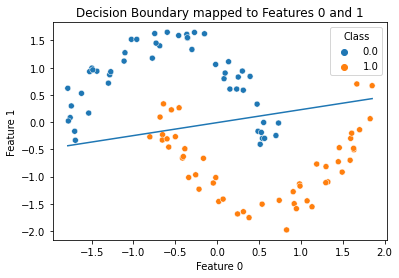

In [17]:
x_train, x_test, y_train, y_test = generate_halfmoon(100, 100)
w, b, l1, g1 = fit(x_train, y_train, bs=10, epochs=1000, lr=.1)
y_pred  = predict(x_test, w, b)
plot_decision_boundary(x_train, y_train, w, b)
print("Accuracy is {}%".format(np.mean(y_pred == y_test)))
print("Recall is {}%" .format(precision_score(y_test, y_pred)))
print("Precision is {}%" .format(recall_score(y_test, y_pred)))

Accuracy is 0.9%
Recall is 0.9347826086956522%
Precision is 0.86%


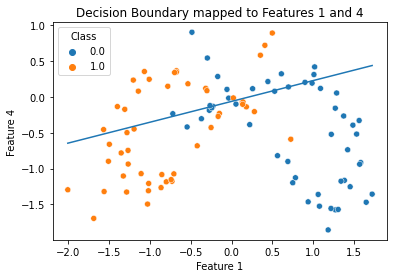

In [18]:
x_train, x_test, y_train, y_test = generate_halfmoon(100, 100)
x_train = pd.DataFrame(x_train)
x_test = pd.DataFrame(x_test)

# Feature map 2
x_train[2] = x_train[0] ** 2
x_train[3] = x_train[1] ** 2
x_train[4] = x_train[0] * x_train[1]
x_test[2] = x_test[0] ** 2
x_test[3] = x_test[1] ** 2
x_test[4] = x_test[0] * x_test[1]


w, b, l2, g2 = fit(x_train, y_train, bs=10, epochs=1000, lr=.1)
y_pred  = predict(x_test, w, b)
plot_decision_boundary(x_train, y_train, w, b, features = [1,4])
print("Accuracy is {}%".format(np.mean(y_pred == y_test)))
print("Recall is {}%" .format(precision_score(y_test, y_pred)))
print("Precision is {}%" .format(recall_score(y_test, y_pred)))

Accuracy is 1.0%
Recall is 1.0%
Precision is 1.0%


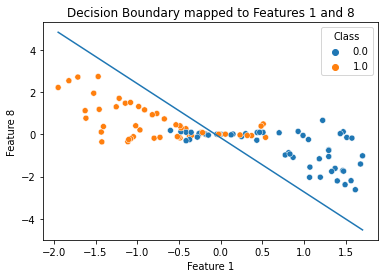

In [36]:
x_train, x_test, y_train, y_test = generate_halfmoon(100, 100)
x_train = pd.DataFrame(x_train)
x_test = pd.DataFrame(x_test)
# Feature map 3
x_train[2] = x_train[0] ** 2
x_train[3] = x_train[1] ** 2
x_train[4] = x_train[0] * x_train[1]
x_train[5] = x_train[0] ** 3
x_train[6] = x_train[1] ** 3
x_train[7] = x_train[0] ** 2 *  x_train[1]
x_train[8] = x_train[0] * x_train[1] ** 2

x_test[2] = x_test[0] ** 2
x_test[3] = x_test[1] ** 2
x_test[4] = x_test[0] * x_test[1]
x_test[5] = x_test[0] ** 3
x_test[6] = x_test[1] ** 3
x_test[7] = x_test[0] ** 2 *  x_test[1]
x_test[8] = x_test[0] * x_test[1] ** 2


w, b, l3, g3 = fit(x_train, y_train, bs=100, epochs=1000, lr=.1)
y_pred  = predict(x_test, w, b)
plot_decision_boundary(x_train, y_train, w, b, features = [1, 8])
print("Accuracy is {}%".format(np.mean(y_pred == y_test)))
print("Recall is {}%" .format(precision_score(y_test, y_pred)))
print("Precision is {}%" .format(recall_score(y_test, y_pred)))

Text(0, 0.5, 'Loss')

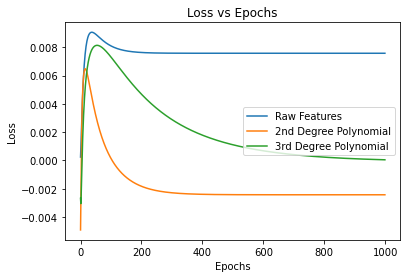

In [20]:
plt.plot(l1)
plt.plot(l2)
plt.plot(l3)
plt.legend(["Raw Features", "2nd Degree Polynomial", "3rd Degree Polynomial"])
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")

# Problem 2

## Gradient Descent

In [21]:
x_train, x_test, y_train, y_test = generate_halfmoon(100, 100)
w, b, l1, g1 = fit(x_train, y_train, bs=100, epochs=10000, lr=.01)
y_pred  = predict(x_test, w, b)
# plot_decision_boundary(x_train, y_train, w, b)
print("Accuracy is {}%".format(np.mean(y_pred == y_test)))
print("Recall is {}%" .format(precision_score(y_test, y_pred)))
print("Precision is {}%" .format(recall_score(y_test, y_pred)))

Accuracy is 0.89%
Recall is 0.9333333333333333%
Precision is 0.84%


## Accelerated Gradient Descent

In [22]:
x_train, x_test, y_train, y_test = generate_halfmoon(100, 100)
w, b, l2, g2 = fit(x_train, y_train, bs=100, epochs=10000, lr=.01, method = 'accelerated')
y_pred  = predict(x_test, w, b)
# plot_decision_boundary(x_train, y_train, w, b)
print("Accuracy is {}%".format(np.mean(y_pred == y_test)))
print("Recall is {}%" .format(precision_score(y_test, y_pred)))
print("Precision is {}%" .format(recall_score(y_test, y_pred)))

Accuracy is 0.89%
Recall is 0.8979591836734694%
Precision is 0.88%


## Adaptive Gradient Descent

In [23]:
x_train, x_test, y_train, y_test = generate_halfmoon(100, 100)
w, b, l3, g3 = fit(x_train, y_train, bs=100, epochs=10000, lr=.01, method = 'adaptive')
y_pred  = predict(x_test, w, b)
# plot_decision_boundary(x_train, y_train, w, b)
print("Accuracy is {}%".format(np.mean(y_pred == y_test)))
print("Recall is {}%" .format(precision_score(y_test, y_pred)))
print("Precision is {}%" .format(recall_score(y_test, y_pred)))

Accuracy is 0.93%
Recall is 0.9387755102040817%
Precision is 0.92%


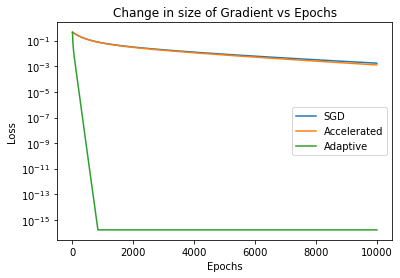

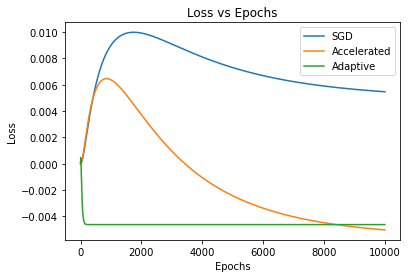

In [24]:
plt.plot(g1)
plt.plot(g2)
plt.plot(g3)
plt.legend(["SGD", "Accelerated", "Adaptive"])
plt.title("Change in size of Gradient vs Epochs")
plt.xlabel("Epochs")
plt.yscale('log')
plt.ylabel("Loss")
plt.show()

plt.plot(l1)
plt.plot(l2)
plt.plot(l3)
plt.legend(["SGD", "Accelerated", "Adaptive"])
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
# plt.yscale('log')
plt.ylabel("Loss");
plt.show()

As we can see, the adaptive gradient descent method converges fastest while the accelerated method marginal improvements over the vanilla method when we examine it with respect to the marginal accuracy. However, we get somewhat conflicting results when we look at the loss. We see that the accelerated method converges to a lower loss than the adaptive method, but takes more time to do so, suggesting that the adaptive method has fallen into a local minimum. The vanilla method coverges the slowest but offers marginal loss benefits over the accelerated method. All of this is largely dependent on the initial learning rate since that drastically effects both the accelerated and stochastic gradient methods, which is explored below.

# Problem 3

Text(0, 0.5, 'Loss')

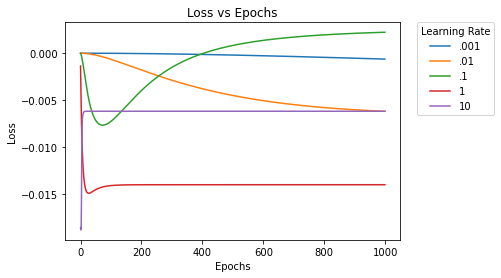

In [13]:
x_train, x_test, y_train, y_test = generate_halfmoon(100, 100)
w, b, l1, g1 = fit(x_train, y_train, bs=100, epochs=1000, lr=.001, method = 'sgd')
y_pred1  = predict(x_test, w, b)
x_train, x_test, y_train, y_test = generate_halfmoon(100, 100)
w, b, l2, g2 = fit(x_train, y_train, bs=100, epochs=1000, lr=.01, method = 'sgd')
y_pred2  = predict(x_test, w, b)
x_train, x_test, y_train, y_test = generate_halfmoon(100, 100)
w, b, l3, g3 = fit(x_train, y_train, bs=100, epochs=1000, lr=.1, method = 'sgd')
y_pred3  = predict(x_test, w, b)
x_train, x_test, y_train, y_test = generate_halfmoon(100, 100)
w, b, l4, g4 = fit(x_train, y_train, bs=100, epochs=1000, lr=1, method = 'sgd')
y_pred4  = predict(x_test, w, b)
x_train, x_test, y_train, y_test = generate_halfmoon(100, 100)
w, b, l5, g5 = fit(x_train, y_train, bs=100, epochs=1000, lr=10, method = 'sgd')
y_pred5  = predict(x_test, w, b)
plt.plot(l1)
plt.plot(l2)
plt.plot(l3)
plt.plot(l4)
plt.plot(l5)
plt.legend(labels = ['.001', '.01', '.1', '1', '10'], title = "Learning Rate", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")

# Problem 4

In [32]:
REGULARIZATION = .01
LEARNING_RATE = 0.000001

def compute_cost(W, x, Y):
    # calculate hinge loss
    N = x.shape[0]
    distances = 1 - Y * (np.dot(x, W))
    distances[distances < 0] = 0
    hinge_loss = REGULARIZATION * (np.sum(distances) / N)
    
    # calculate cost
    cost = 1 / 2 * np.dot(W, W) + hinge_loss
    return cost

def calculate_cost_gradient(W, x_batch, Y_batch):
    # if only one example is passed (eg. in case of SGD)
    if type(Y_batch) == np.float64:
        Y_batch = np.array([Y_batch])
        x_batch = np.array([x_batch])    
        distance = 1 - (Y_batch * np.dot(x_batch, W))
        dw = np.zeros(len(W))    
        for ind, d in enumerate(distance):
            if max(0, d) == 0:
                di = W
            else:
                di = W - (REGULARIZATION * Y_batch[ind] * x_batch[ind])
            dw += di    
            dw = dw/len(Y_batch)  # average
    return dw

def sgd(features, outputs):
    max_epochs = 5000
    weights = np.zeros(features.shape[1])
    # stochastic gradient descent
    for epoch in range(1, max_epochs): 
        # shuffle to prevent repeating update cycles
        x, Y = shuffle(features, outputs)
        for ind, x in enumerate(x):
            ascent = calculate_cost_gradient(weights, x, Y[ind])
            weights = weights - (LEARNING_RATE * ascent)
            
    return weights
    

In [33]:
W = sgd(x_train, y_train)

In [34]:
set(y_train)

{0.0, 1.0}

In [35]:
y_test_predicted = np.array([])
for i in range(x_test.shape[0]):
    yp = np.sign(np.dot(W, x_test[i])) #model
    y_test_predicted = np.append(y_test_predicted, yp)
print("accuracy on test dataset: {}".format(accuracy_score(y_test, y_test_predicted)))
print("recall on test dataset: {}".format(recall_score(y_test, y_test_predicted, average = 'weighted')))
print("precision on test dataset: {}".format(precision_score(y_test, y_test_predicted, average = 'weighted')))

accuracy on test dataset: 0.45
recall on test dataset: 0.45
precision on test dataset: 0.4591836734693878


c:\tools\Anaconda3\envs\deckard\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\tools\Anaconda3\envs\deckard\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
